In [1]:
from cluster_buster import ClusteringExperiment
import iris
import matplotlib.pyplot as plt
import numpy as np
from plotting import quick_reg_plot

/home/dorrington/anaconda3/envs/jupyternb/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/dorrington/anaconda3/envs/jupyternb/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


# In this notebook we demonstrate some example uses of the ClusteringExperiment class:

## First we need some data to test ourselves on. The ClusteringExperiment class takes in principal components and optional regressor variable and field_data inputs, all as iris cubes

In [2]:
ERA_pcs=iris.load_cube("example_files/era_pcs.nc")
ERA_jet_speed=iris.load_cube("example_files/era_jet_speed.nc")
ERA_Z500=iris.load_cube("example_files/era_Z500.nc")

model_pcs1=iris.load_cube("example_files/EC_Earth_HR_r1_pcs.nc")
model_pcs2=iris.load_cube("example_files/EC_Earth_HR_r2_pcs.nc")
model_pcs3=iris.load_cube("example_files/EC_Earth_HR_r3_pcs.nc")
model_z5001=iris.load_cube("example_files/EC_Earth_HR_r1_Z500.nc")
model_z5002=iris.load_cube("example_files/EC_Earth_HR_r2_Z500.nc")
model_z5003=iris.load_cube("example_files/EC_Earth_HR_r3_Z500.nc")

# Example 1: Simply cluster ERA20C data into 4 regimes:

In [3]:
C=ClusteringExperiment(exp_id="ERA20C",pc_cube=ERA_pcs,regressor=None,field_data=ERA_Z500)
C.cluster_pcs(Ks=[4])
C.get_cluster_cubes()

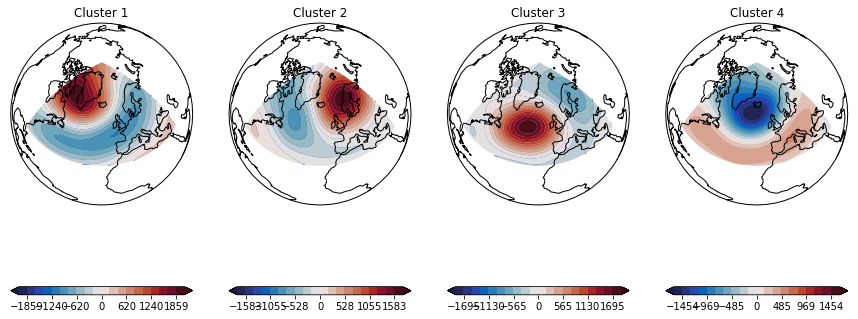

In [4]:
quick_reg_plot(C.get_cc_data("pcs",K=4));

# Example 2: Regress out the impact of jet speed from the PCs, look at the correlation between jet speed and each PC, then cluster for K=3 and K=5

In [5]:
C=ClusteringExperiment(exp_id="regressed_ERA20C",pc_cube=ERA_pcs,regressor=ERA_jet_speed,field_data=ERA_Z500)
C.regress_pcs()
C.cluster_pcs(Ks=[3,5],pc_list=["regressed_pcs"])
C.get_cluster_cubes(pc_list=["regressed_pcs"])

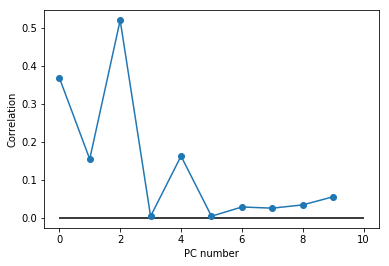

In [6]:
plt.plot(C.regression_correlations,marker="o")
plt.xlabel("PC number")
plt.ylabel("Correlation")
plt.hlines(0,0,10)

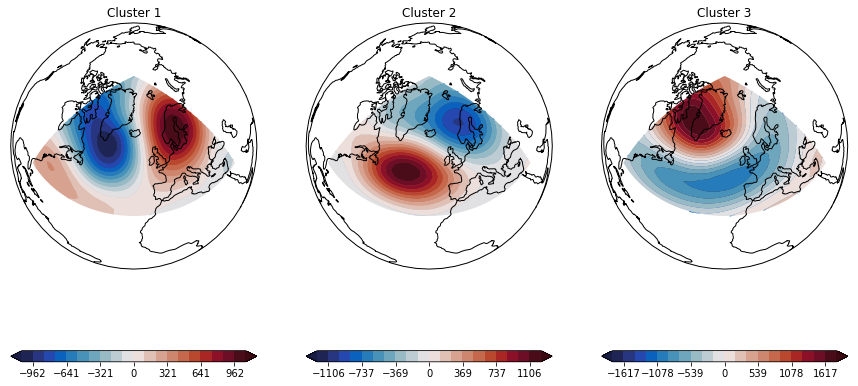

In [7]:
quick_reg_plot(C.get_cc_data("regressed_pcs",K=3));

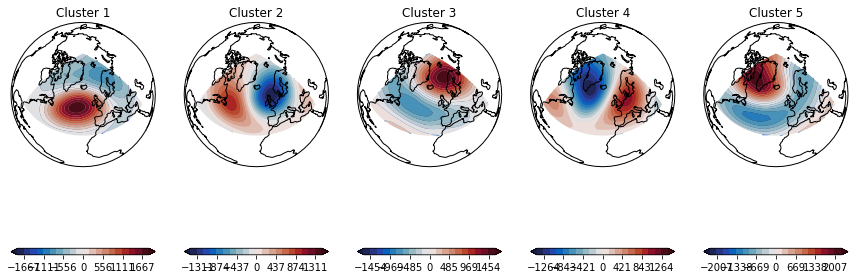

In [8]:
quick_reg_plot(C.get_cc_data("regressed_pcs",K=5));

## Example 3: Regress ERA20C against jet speed, split it into 30 year windows and cluster each window for K=3, then correlate against the centennial windows, and plot the resulting windowed patterns. We see that they have been properly ordered to match the centennial patterns, so we can easily identify properties of different individual regimes:

In [9]:
C=ClusteringExperiment(exp_id="regressed_ERA20C",pc_cube=ERA_pcs,regressor=ERA_jet_speed,field_data=ERA_Z500)
C.regress_pcs()

window=30*90 #in days, so 30 seasons
overlap=10*90 #Move each window on 10 years
C.window_data(window,overlap)

C.cluster_pcs(Ks=[3],pc_list=["regressed_pcs","windowed_regressed_pcs"])
C.get_cluster_cubes(pc_list=["regressed_pcs","windowed_regressed_pcs"])

In [10]:
ref_id="ERA20C_regressed_centennial"
C.correlate_clusters(reference_clusters=C.cluster_cubes["regressed_pcs"],pc_list=["windowed_regressed_pcs"],reorder_clusters=True,reference_id=ref_id)

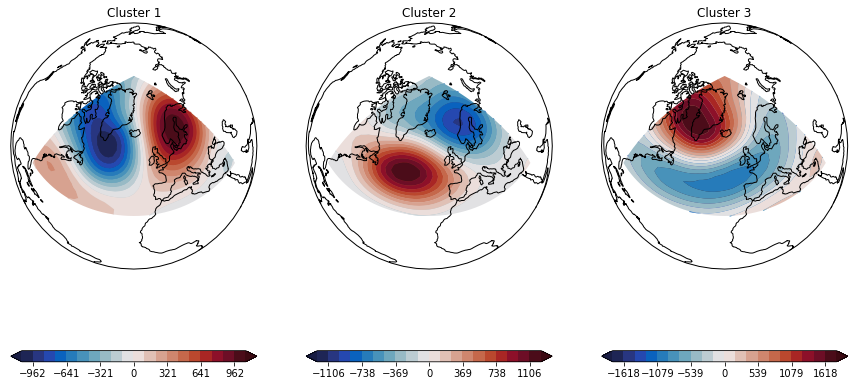

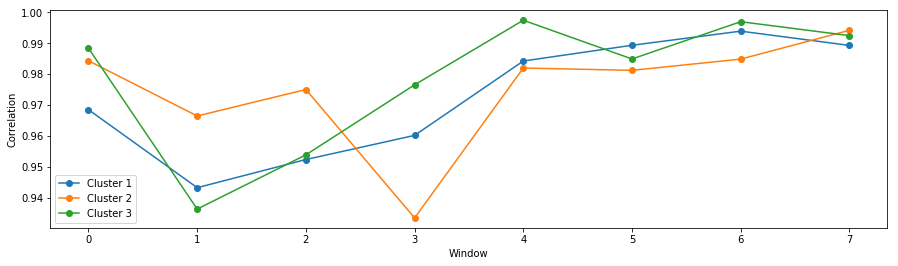

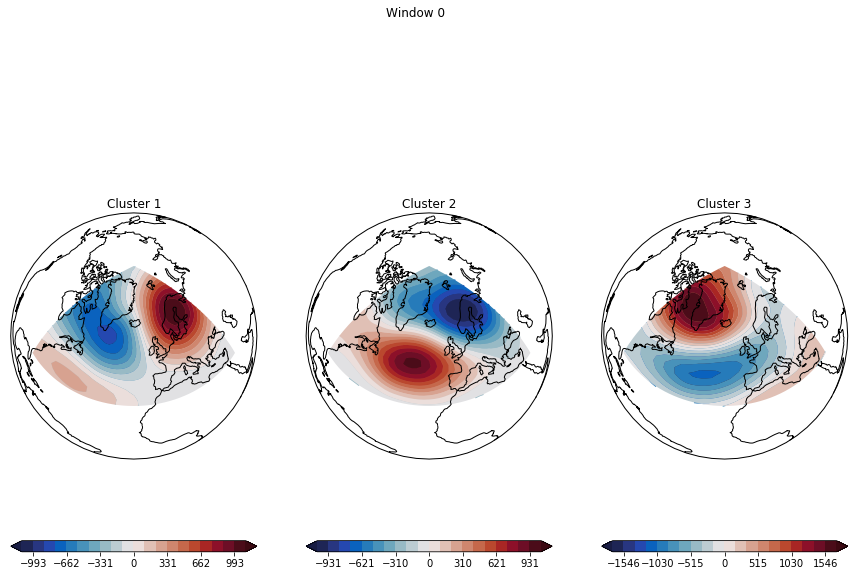

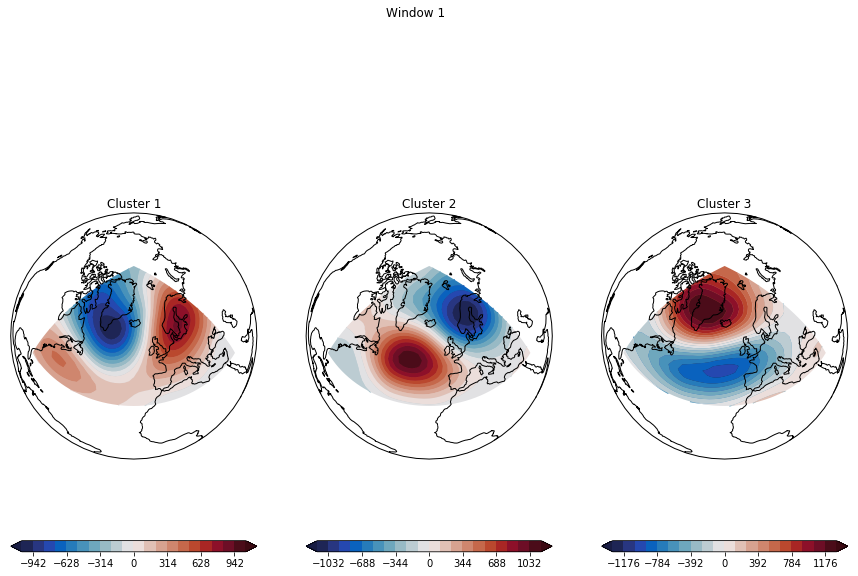

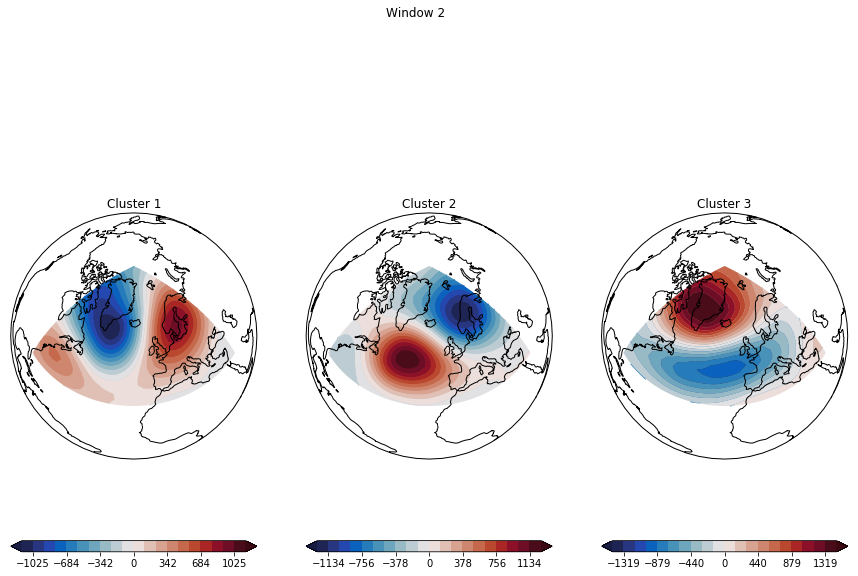

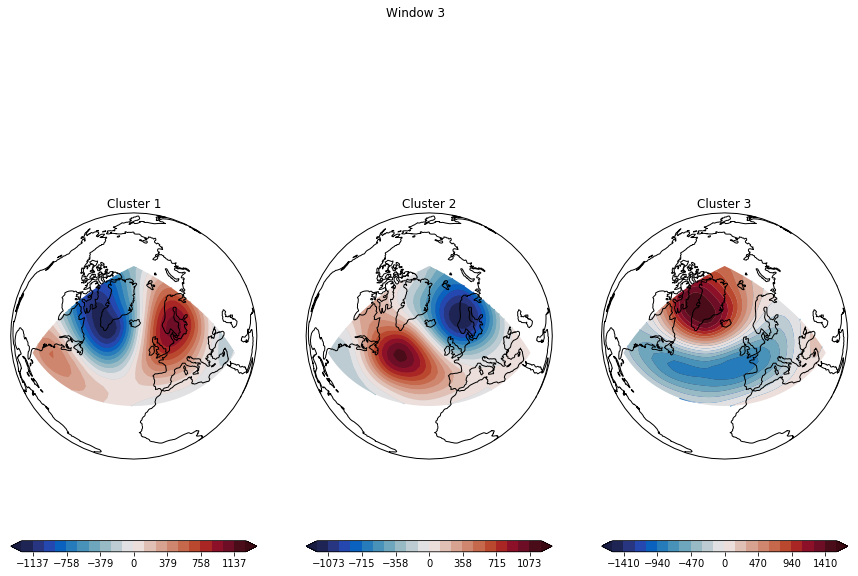

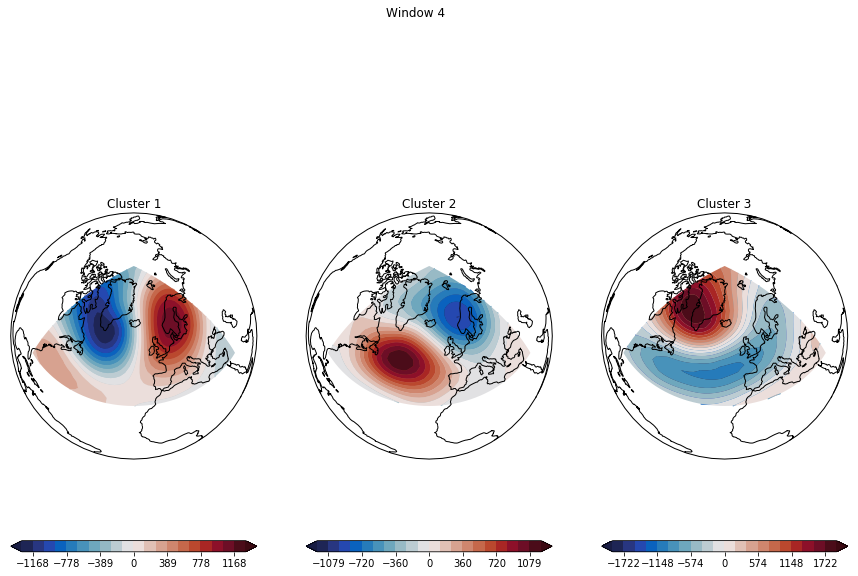

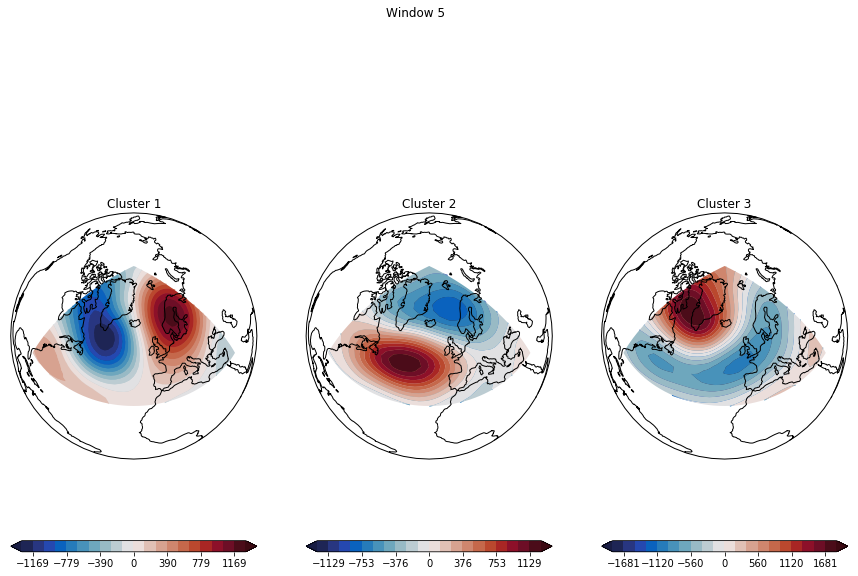

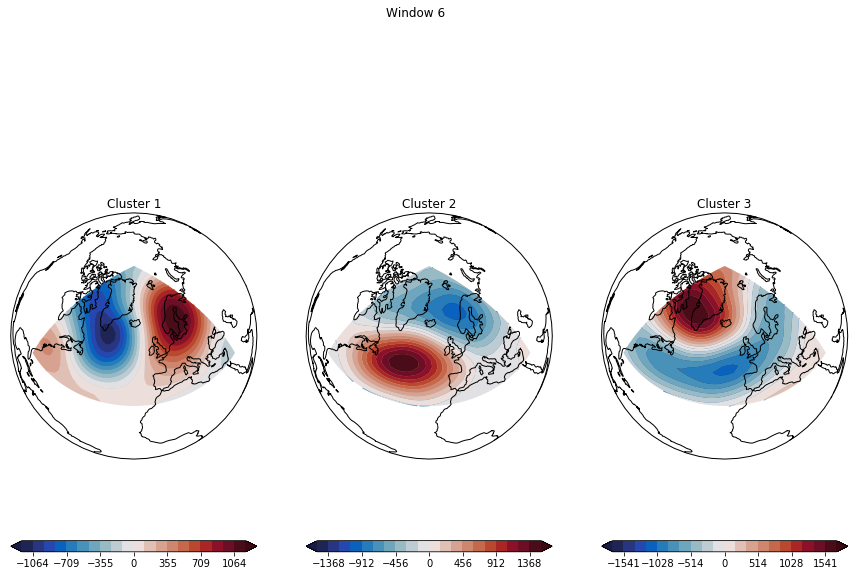

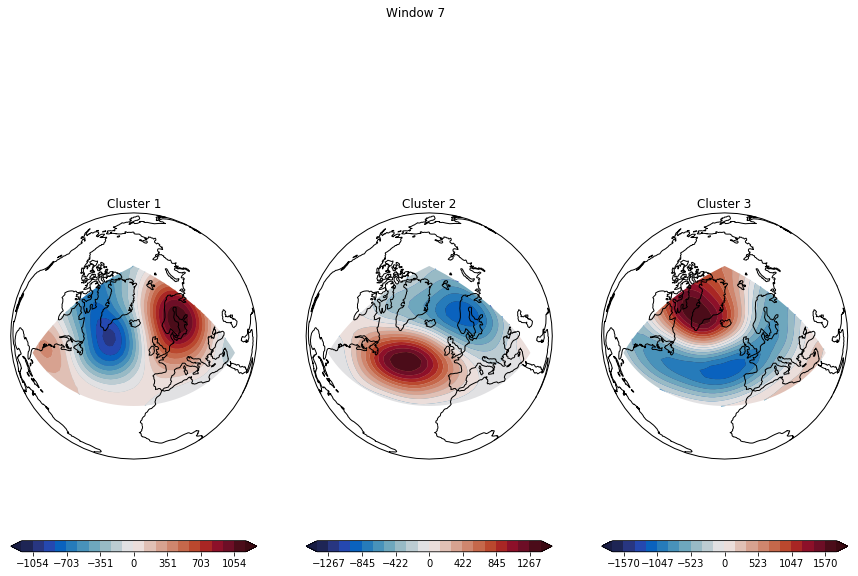

In [11]:
quick_reg_plot(C.get_cc_data("regressed_pcs",K=3))
fig,ax=plt.subplots(1)
fig.set_figwidth(15)
corrs=np.array([[C.cluster_correlations[ref_id]["windowed_regressed_pcs"][1][w][3][k] for k in range (3)] for w in range(8)])

[plt.plot(corrs[:,k],marker="o",label=f"Cluster {k+1}") for k in range(3)]
plt.legend()
plt.xlabel("Window")
plt.ylabel("Correlation")

for w in range(8):
    fig,ax=quick_reg_plot(C.get_cc_data("windowed_regressed_pcs",K=3,window=w))
    fig.suptitle(f"Window {w}")

## Example 4: Load several model runs, combine them into a grand ensemble, and cluster them both altogether and in windows for K=4. Then correlate the windowed clusters with the model ensemble, and with ERA20C

In [12]:
model_pcs1=iris.load_cube("../data/derived_data/primavera_data/pcs/EC-Earth3P-HR_r1i1p2f1_pcs.nc")
model_z5001=load_pickle("../data/raw_data/primavera/u_full_Z500.pkl")["EC-Earth3P-HR_r1i1p2f1"]

model_pcs2=iris.load_cube("../data/derived_data/primavera_data/pcs/EC-Earth3P-HR_r2i1p2f1_pcs.nc")
model_z5002=load_pickle("../data/raw_data/primavera/u_full_Z500.pkl")["EC-Earth3P-HR_r2i1p2f1"]

model_pcs3=iris.load_cube("../data/derived_data/primavera_data/pcs/EC-Earth3P-HR_r3i1p2f1_pcs.nc")
model_z5003=load_pickle("../data/raw_data/primavera/u_full_Z500.pkl")["EC-Earth3P-HR_r3i1p2f1"]


In [13]:
#Get the model clusters
C1=ClusteringExperiment(exp_id="model_1",pc_cube=model_pcs1,regressor=None,field_data=model_z5001)
C2=ClusteringExperiment(exp_id="model_2",pc_cube=model_pcs2,regressor=None,field_data=model_z5002)
C3=ClusteringExperiment(exp_id="model_3",pc_cube=model_pcs3,regressor=None,field_data=model_z5003)

C_ensemble=C1.combine_with([C2,C3],new_id="model_ensemble")

width=50*90
offset=20*90
C_ensemble.window_data(width,offset)
C_ensemble.cluster_pcs(Ks=[4])
C_ensemble.get_cluster_cubes()

In [14]:
#Get the era clusters
C_ERA=ClusteringExperiment(exp_id="era",pc_cube=ERA_pcs,regressor=None,field_data=ERA_Z500)
C_ERA.cluster_pcs(Ks=[4])
C_ERA.get_cluster_cubes()

In [15]:
#Correlate the windows with the full ensembles

model_reference_clusters=C_ensemble.cluster_cubes["pcs"]
era_reference_clusters=C_ERA.cluster_cubes["pcs"]

C_ensemble.correlate_clusters(reference_clusters=era_reference_clusters,pc_list=["windowed_pcs"],reorder_clusters=False,reference_id="ERA_centennial")
C_ensemble.correlate_clusters(reference_clusters=model_reference_clusters,pc_list=["windowed_pcs"],reorder_clusters=False,reference_id="model_ensemble")


Text(0,0.5,'Correlation')

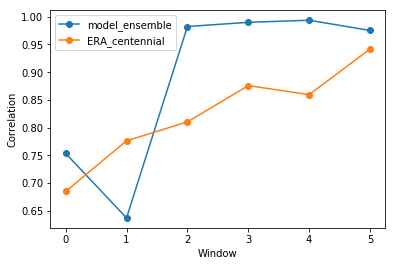

In [16]:
mean_ens_corr=[C_ensemble.cluster_correlations["model_ensemble"]["windowed_pcs"][0][w][4] for w in range(6)]
mean_era_corr=[C_ensemble.cluster_correlations["ERA_centennial"]["windowed_pcs"][0][w][4] for w in range(6)]

plt.plot(mean_ens_corr,label="model_ensemble",marker="o")
plt.plot(mean_era_corr,label="ERA_centennial",marker="o")
plt.legend()
plt.xlabel("Window")
plt.ylabel("Correlation")